This notebook generates the values reported in the text of `Systematic over-crediting in California’s forest carbon offsets program`

In [111]:
from collections import Counter
import fsspec
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from carbonplan_forest_offsets.analysis.project_crediting_error import get_slag_to_total_scalar
from carbonplan_forest_offsets.data import cat, get_retro_bucket, get_temp_bucket
from carbonplan_forest_offsets.load.issuance import load_issuance_table, ifm_opr_ids

In [14]:
df = load_issuance_table(forest_only=False)
retro_json = cat.retro_db_light_json.read()

## Total Value


In [15]:
total_arbocs = df["allocation"].sum()
display(total_arbocs)

price_per_arboc = 13.67

display(price_per_arboc * total_arbocs)

192996530.0

2638262565.1

### figure 1a
data also posted to results via `analysis/summarize_issuance.py

In [25]:
def subset_stats(criteria):
    nunique_opr_ids = df[criteria]["opr_id"].nunique()
    total_arbocs = (df[criteria]["allocation"].sum() / 1_000_000).round(1)
    return (nunique_opr_ids, total_arbocs)


upfront_opr_ids = [
    project["opr_id"]
    for project in retro_json
    if project["carbon"]["initial_carbon_stock"]["value"]
    > project["carbon"]["common_practice"]["value"]
]
compliance_opr_ids = [project["opr_id"] for project in retro_json]

subsets = {
    "all": np.tile(True, len(df)),
    "all_forest": df["project_type"] == "forest",
    "compliance_ifm": (df["opr_id"].isin(ifm_opr_ids)) & (df["Early Action/ Compliance"] == "COP"),
    "non_graduated_compliance_ifms": (df["opr_id"].isin(compliance_opr_ids))
    & (df["Early Action/ Compliance"] == "COP"),
    "upfront_ifm": (df["opr_id"].isin(upfront_opr_ids)) & (df["arb_rp_id"].isin(["A"])),
}

summary = {k: subset_stats(v) for k, v in subsets.items()}
display(summary)

{'all': (474, 193.0),
 'all_forest': (130, 156.1),
 'compliance_ifm': (93, 137.1),
 'non_graduated_compliance_ifms': (74, 131.5),
 'upfront_ifm': (72, 121.0)}

In [27]:
summary['upfront_ifm'][1] / summary['all_forest'][1]

0.7751441383728379

In [26]:
summary['upfront_ifm'][1] / summary['all'][1]

0.6269430051813472

## Carbon stocks for SC by species


In [ ]:
sc_data = cat.rfia_all(assessment_area_id=297).read()

sc_data = sc_data[sc_data["YEAR"] == 2010].copy()  # use 2010 because comporable to CP data


sc_data["CARB_ACRE"] = sc_data["CARB_ACRE"] * 44 / 12 * 0.907185

In [ ]:
fortyps_of_interest = {"Douglas fir": 201, "Ponderosa pine": 221, "Tanoak": 941}

In [ ]:
standing_carbon = {}
for k, v in fortyps_of_interest.items():
    standing_carbon[k] = round(sc_data.loc[sc_data["FORTYPCD"] == v, "CARB_ACRE"].item(),1)
display(standing_carbon)

### Coastal Alaska


In [ ]:
# ak has three assessment areas but lets summarize across all to report inline value
ak_assessment_areas = [285, 286, 287]
ak_all = pd.concat([cat.rfia_all(assessment_area_id=aa_id).read() for aa_id in ak_assessment_areas])

ak_all = ak_all[ak_all["YEAR"] == 2013].copy()  # 2013 to match what used in CP

sums = ak_all.groupby("FORTYPCD").sum()[["CARB_TOTAL", "AREA_TOTAL", "nPlots_TREE"]]

In [ ]:
ak_forests_of_interest = {
    "Sitka sprice": 305,
    "Western hemlock": 301,
    "Cottonwood": 703,
    "Paper birch": 902,
}

In [ ]:
ak_carb_acre = sums["CARB_TOTAL"] / sums["AREA_TOTAL"] * 44 / 12 * 0.907185

display({k: ak_carb_acre[v].round(1) for k, v in ak_forests_of_interest.items()})

### Project Examples


In [32]:
fs_prefix, fs_kwargs = get_retro_bucket()
fn = f"{fs_prefix}/results/reclassification-crediting-error.json"
with fsspec.open(fn, mode="r", **fs_kwargs) as f:
    reclass_credit = json.load(f)

In [33]:
def summarize_project(project):
    crediting_error = np.percentile(
        reclass_credit[project["opr_id"]]["delta_arbocs"], q=[5, 50, 95]
    ).round(1)

    as_frac = crediting_error / project["arbocs"]["calculated"]
    print(f"{project['opr_id']} has a {crediting_error[1]} crediting error ({as_frac[1].round(3)})")
    print(f"CI: {crediting_error[0]}, {crediting_error[2]}")
    print(f"% CI: {as_frac[0].round(3)}, {as_frac[2].round(3)}")

In [34]:
opr_id = "ACR189"
project = [x for x in retro_json if x["opr_id"] == opr_id][0]

summarize_project(project)

ACR189 has a 135869.2 crediting error (0.501)
CI: 85480.8, 185916.6
% CI: 0.315, 0.686


In [ ]:
opr_id = "ACR361"
project = [x for x in retro_json if x["opr_id"] == opr_id][0]

summarize_project(project)

In [ ]:
opr_id = "CAR1183"
project = [x for x in retro_json if x["opr_id"] == opr_id][0]

summarize_project(project)

### Ecosection combos


In [2]:
fs_prefix, fs_kwargs = get_retro_bucket()

In [3]:
fn = f'{fs_prefix}/results/297_by_ecosection.csv'

In [4]:
with fsspec.open(fn, mode='r', **fs_kwargs) as f:
    data = pd.read_csv(f)
    
data = data[data["YEAR"] == 2010]  # match CP calculation period

In [5]:
data["ECOSECTION"] = data["ECOSUBCD"].str[:-1].str.strip()


lst = ["M261A", "M261B", "M261D"]  # ['263A']# ["M221A","M221B","M221C"] #['263A']#
subset = data[(data["CARB_TOTAL"] > 0) & (data["ECOSECTION"].isin(lst))].copy()

In [6]:
sums = subset.groupby(["site", "ECOSECTION"])[["CARB_TOTAL", "AREA_TOTAL"]].sum()
slag = sums["CARB_TOTAL"] / sums["AREA_TOTAL"] * 44 / 12 * 0.907185

In [7]:
ss_average = subset.groupby(["site"])[["CARB_TOTAL", "AREA_TOTAL"]].sum()

In [8]:
ss_slag = ss_average["CARB_TOTAL"] / ss_average["AREA_TOTAL"] * 44 / 12 * 0.907185

In [9]:
slag.unstack(1).round(1)

ECOSECTION,M261A,M261B,M261D
site,,,
high,120.6,150.5,100.6
low,95.2,106.4,53.2


In [11]:
((ss_slag - slag) / slag).unstack(0)

site,high,low
ECOSECTION,,
M261A,-0.013284,-0.161891
M261B,-0.209140,-0.250049
M261D,0.183504,0.499957


In [29]:
(121.8 - 150.5)/150.5

-0.19069767441860466

# Methods


## Classifier


In [31]:
fn

'az://carbonplan-retro/results/reclassification/classifier_fscores.json'

In [36]:
fs_prefix, fs_kwargs = get_retro_bucket()
fn = f"{fs_prefix}/reclassification/classifier_fscores.json"
with fsspec.open(fn, mode="r", **fs_kwargs) as f:
    fscores = json.load(f)

In [37]:
np.median([scores[0] for ss_name, scores in fscores.items()])

0.77988012574225

In [38]:
table = (
    pd.Series({ss_name: round(scores[0], 2) for ss_name, scores in fscores.items()})
    .sort_values(ascending=False)
    .rename("Weighted F-Score")
    .to_frame()
)

In [39]:
table.index = table.index.set_names("Superseciton")

In [40]:
table

,Weighted F-Score
Superseciton,
Central New Mexico,0.94
White Mountains - San Francisco Peaks - Mongollon,0.93
Southeast and South Central Alaska,0.91
Columbia Basin,0.89
Okanogan Highland,0.88
Northwest Cascades,0.87
Southern Cascades,0.82
Laurentian Mixed Forest Southern Superior,0.79
Maine - New Brunswick Foothills and Lowlands,0.78


## Common Practice Stuff


In [41]:
projects = [
    x
    for x in retro_json
    if x["carbon"]["initial_carbon_stock"]["value"] > x["carbon"]["common_practice"]["value"]
]

In [42]:
cp_df = pd.DataFrame(
    [
        (
            project["carbon"]["average_slag_baseline"]["value"],
            project["carbon"]["common_practice"]["value"],
        )
        for project in projects
    ],
    columns=["baseline", "cp"],
)

## Figure 2 Caption
What percent of projects are within 5 percent of common practice?

In [44]:
sum((cp_df["baseline"] <= cp_df["cp"] * 1.05)) / len(cp_df.dropna())

0.8923076923076924

# Extended Methods

In [62]:
fs_prefix, fs_kwargs = get_temp_bucket()
fn = f"{fs_prefix}/results/common-practice-verification.json"
with fsspec.open(fn, mode="r", **fs_kwargs) as f:
    cp_verification = json.load(f)

In [106]:
data = pd.DataFrame(cp_verification['assessment_areas'])[['common_practice', 'rfia']]
mean_squared_error(data['common_practice'], data['rfia']) ** 0.5

5.209087663866994

In [110]:
data = pd.DataFrame(cp_verification['projects'])[['recalculated', 'project_reported']]
mean_squared_error(data['recalculated'], data['project_reported']) ** 0.5

9.757829445418926

In [208]:
data['diff'] = (data['recalculated'] - data['project_reported'])/(data['project_reported'])
data = data[np.isfinite(data['diff'])] # CAR1186 = infite bc original CP = 0.

In [209]:
data['diff'].mean()  

0.03226222826616072

In [210]:
error_cp0 = data.set_index('opr_id')['diff']

## Project scalars
ratio of above ground to below ground carbon

In [211]:
pd.DataFrame([get_slag_to_total_scalar(project) for project in projects]).describe()

,0
count,72.000000
mean,1.236618
std,0.040171
min,1.027692
25%,1.222765
50%,1.242870
75%,1.260140
max,1.298649


## IFM-3
IFM-3 in the baseline scenario and project scenario are equal

In [136]:
sum([x["rp_1"]["ifm_3"] == x["baseline"]["ifm_3"] for x in projects]) / len(projects)

0.5416666666666666

In [220]:
fs_prefix, fs_kwargs = get_retro_bucket()
fn = f"{fs_prefix}/results/reclassification-crediting-error.json"
with fsspec.open(fn, mode="r", **fs_kwargs) as f:
    crediting_error = json.load(f)

crediting_df = pd.DataFrame({k: v["delta_arbocs"] for k, v in crediting_error.items()})

median_crediting_error = {k: np.median(v["delta_arbocs"]) for k, v in crediting_error.items()}

In [224]:
tp = pd.concat(
    [
        pd.Series(median_crediting_error).rename("crediting_error"),
        error_cp0.rename('cp')
    ],
    axis=1,
)

In [225]:
tp.dropna().corr()

,crediting_error,cp
crediting_error,1.000000,0.059385
cp,0.059385,1.000000


/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


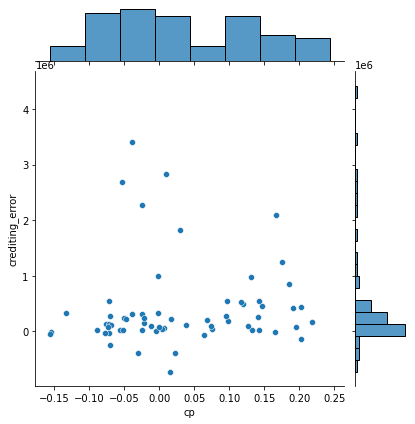

In [226]:
sns.jointplot("cp", "crediting_error", data=tp)

# Disucssion
## Data limitations

### Plots in AK


In [47]:
ak_assessment_areas = [285, 286, 287]
ak_all = pd.concat([cat.rfia_all(assessment_area_id=aa_id).read() for aa_id in ak_assessment_areas])

In [48]:
ak_all = ak_all[ak_all["YEAR"] == 2013]

In [49]:
plots_by_aa = ak_all.groupby("Assessment")["nPlots_TREE"].sum()
display(plots_by_aa)

Assessment
Alaska Range Transition            58
Alexander Archipelago - Kodiak    161
Gulf-NorthCoast-Chugach            79
Name: nPlots_TREE, dtype: int64

In [54]:
sum([project["arbocs"]["issuance"] for project in retro_json if 287 in project["supersection_ids"]])

9517975.0

In [50]:
# total AK plots
display(plots_by_aa.sum())

298

Contrasted against 297 (mixed conifer)

In [61]:
sc = cat.rfia_all(assessment_area_id=297).read()
sc[sc["YEAR"] == 2010].nPlots_TREE.sum()

545